In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.svm import LinearSVC

from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd

from matplotlib import pyplot as plt
import time as t
import random

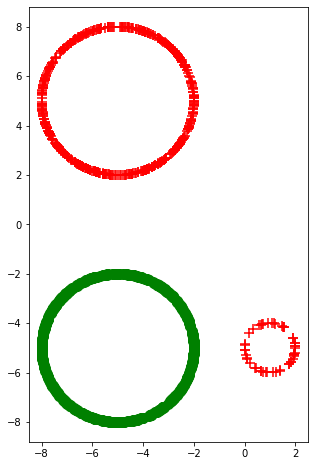

In [3]:
d = 2 
n = 500

muPos1 = np.array( [-5,5] )
muPos2 = np.array( [1,-5] )
muNeg = np.array( [-5,-5] )
r = 3

nOutlier = n//10
rOutlier = r//2

tmp1 = gsd.genSphericalData( d, n, muPos1, r)
tmp2 = gsd.genSphericalData( d, nOutlier, muPos2, rOutlier )
XPos = np.vstack( (tmp1, tmp2) )
XNeg = gsd.genSphericalData( d, n, muNeg, r )
yPos = np.ones( (n + nOutlier,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

fig = pd.getFigure( 5, 8 )
pd.plot2D( XPos, fig, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )

In [4]:
def mySVM( X ):
    return X.dot(w) + b

# Stochastic Dual Coordinate Maximization
def doCoordOptCSVMDual( alpha, i, t ):
    global w_SDCM, b_SDCM, normSq
    x = X[i,:]
    
    # Find the unconstrained new optimal value of alpha_i
    # It takes only O(d) time to do so because of our clever book keeping
    newAlphai =  alpha[i] + (1 - y[i] * (x.dot(w_SDCM) + b_SDCM)) / normSq[i]
    
    # Make sure that the constraints are satisfied. This takes only O(1) time
    if newAlphai > C:
        newAlphai = C
    if newAlphai < 0:
        newAlphai = 0

    # Update the primal model vector and bias values to ensure bookkeeping is proper
    # Doing these bookkeeping updates also takes only O(d) time
    w_SDCM = w_SDCM + (newAlphai - alpha[i]) * y[i] * x
    b_SDCM = b_SDCM + (newAlphai - alpha[i]) * y[i]
    
    return newAlphai

# Get the primal and the dual CSVM objective values in order to plot convergence curves
# This is required for the dual solver which optimizes the dual objective function
def getCSVMPrimalDualObjVals( alpha ):
    global w_SDCM, b_SDCM
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w_SDCM ) + b_SDCM), y ), 0 )
    objPrimal = 0.5 * w_SDCM.dot( w_SDCM ) + C * np.sum(hingeLoss)
    # Recall that b is supposed to be treated as the last coordinate of w
    objDual = np.sum( alpha ) - 0.5 * np.square( np.linalg.norm( w_SDCM ) ) - 0.5 * b_SDCM * b_SDCM
    
    return np.array( [objPrimal, objDual] )

# Given a coordinate update oracle and a coordinate selection oracle, implement coordinate methods
# The method returns the final model and the objective value acheived by the intermediate models
# This can be used to implement coordinate descent or ascent as well as coordinate minimization or
# maximization methods simply by modifying the coordinate update oracle
def doSDCM( coordUpdateFunc, getCoordFunc, objFunc, init, horizon = 10 ):
    objValSeries = []
    timeSeries = []
    totTime = 0
    selector = getCoordFunc[0] # Get hold of the function that will give me the next coordinate
    state = getCoordFunc[1] # The function needs an internal state variable - store the initial state
    
    # Initialize model as well as some bookkeeping variables
    alpha = init
    
    for it in range( horizon ):
        # Start a stopwatch to calculate how much time we are spending
        tic = t.perf_counter()
        
        # Get the next coordinate to update and update that coordinate
        (i, state) = selector( state )
        alpha[i] = coordUpdateFunc( alpha, i, it )

        toc = t.perf_counter()
        totTime = totTime + (toc - tic)
        
        objValSeries.append( objFunc( alpha ) )
        timeSeries.append( totTime )
        
    return (alpha, objValSeries, timeSeries)

# For randperm mode, the state is a tuple of the random permutation and the current index within that permutation
def getRandpermCoord( state ):
    idx = state[0]
    perm = state[1]
    d = len( perm )
    if idx >= d - 1 or idx < 0:
        idx = 0
        perm = np.random.permutation( d )
    else:
        idx += 1
    state = (idx, perm)
    curr = perm[idx]
    return (curr, state)

# Get functions that offer various coordinate selection schemes
def coordinateGenerator( mode, d ):
    if mode == "cyclic":
        return (getCyclicCoord, (0,d))
    elif mode == "random":
        return (getRandCoord, d)
    elif mode == "randperm":
        return (getRandpermCoord, (0,np.random.permutation( d )))

In [7]:
C = 10
coordFunc = coordinateGenerator( "randperm", y.size )

# Create initializations for the SDCM solver
initDual = C * np.ones( (y.size,) )

# The SDCM solver needs to repeatedly calculate the squared norms of the feature vector.
# Calculate them once and for all to improve efficienty. While calculating the norms, take
# care that we are appending an extra dimension of ones to all feature vectors to hide the bias
normSq = np.square( np.linalg.norm( X, axis = 1 ) ) + 1

# Initialize bookkeeping variables for the SDCM solver.
# Initialize the primal model vector using the equations relating primal and dual variables
alphayInit = np.multiply( initDual, y )
w_SDCM = X.T.dot( alphayInit )
# Recall that we are pretending that the data points have one extra dimension of ones
# This extra dimension plays the role of the bias in this case
b_SDCM = initDual.dot( y )

(alpha_SDCM, obj_SDCM, time_SDCM) = doSDCM( doCoordOptCSVMDual, coordFunc, getCSVMPrimalDualObjVals, initDual, horizon = 10 * n )

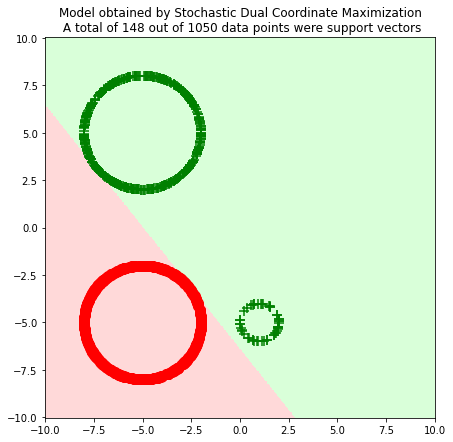

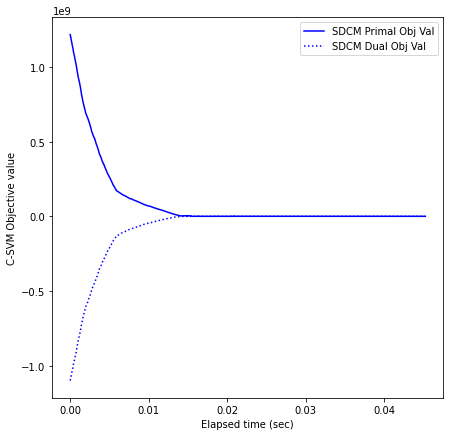

In [8]:
w = w_SDCM
b = b_SDCM

fig3 = pd.getFigure( 7, 7 )
pd.shade2D( mySVM, fig3, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig3, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig3, color = 'r', marker = 'o' )
plt.title( "Model obtained by Stochastic Dual Coordinate Maximization\n A total of %d out of %d data points were support vectors" % (np.sum( alpha_SDCM > C/100 ), y.size) )
plt.show()

fig4 = pd.getFigure( 7, 7 )
plt.figure( fig4.number )
primal_SDCM = [obj_SDCM[i][0] for i in range(len(obj_SDCM))]
dual_SDCM = [obj_SDCM[i][1] for i in range(len(obj_SDCM))]
plt.plot( time_SDCM, primal_SDCM, color = 'b', linestyle = '-', label = "SDCM Primal Obj Val" )
plt.plot( time_SDCM, dual_SDCM, color = 'b', linestyle = ':', label = "SDCM Dual Obj Val" )
plt.legend()
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )

plt.show()

In [19]:
data = np.loadtxt( "APUF_CRP.txt" )

def createFeatures( X ):
    return np.cumprod( np.flip( 2 * X - 1 , axis = 1 ), axis = 1 )

data_trn, data_tst = train_test_split( data, train_size = 1000 )

X_raw = data_trn[:,:-1]
X = createFeatures( X_raw )
y = data_trn[:,-1]

y = np.where( y > 0, 1, -1 )

X_t_raw = data_tst[:,:-1]
X_t = createFeatures( X_t_raw )
y_t = data_tst[:,-1]

y_t = np.where( y_t > 0, 1, -1 )

clf = LinearSVC( loss = "hinge" )
clf.fit( X, y )
np.average( y_t == clf.predict( X_t ) )

C:\Users\purus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9726767676767677

In [20]:
np.unique( y )

array([-1,  1])

In [26]:
C = 1

coordFunc = coordinateGenerator( "randperm", y.size )

initDual = C * np.ones( ( y.size, ) )

normSq = np.square( np.linalg.norm( X, axis = 1 ) ) + 1

alphayInit = np.multiply( initDual, y )
w_SDCM = X.T.dot( alphayInit )

b_SDCM = initDual.dot( y )

(alpha_SDCM, obj_SDCM, time_SDCM) = doSDCM( doCoordOptCSVMDual, coordFunc, getCSVMPrimalDualObjVals, initDual, horizon = 20000 )

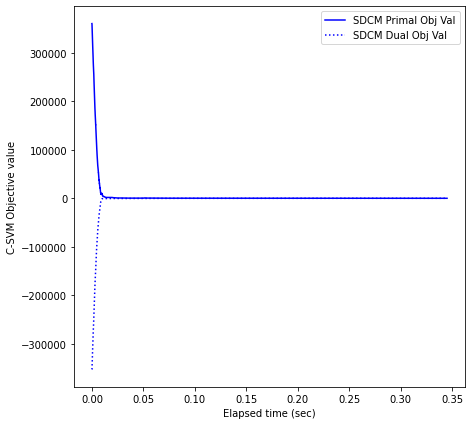

In [27]:
fig5 = pd.getFigure( 7, 7 )
plt.figure( fig5.number )
primal_SDCM = [obj_SDCM[i][0] for i in range(len(obj_SDCM))]
dual_SDCM = [obj_SDCM[i][1] for i in range(len(obj_SDCM))]
plt.plot( time_SDCM, primal_SDCM, color = 'b', linestyle = '-', label = "SDCM Primal Obj Val" )
plt.plot( time_SDCM, dual_SDCM, color = 'b', linestyle = ':', label = "SDCM Dual Obj Val" )
plt.legend()
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )

# plt.ylim( min(dual_SDCM[-500:]), max(primal_SDCM[-500:]) )

plt.show()

In [28]:
w = w_SDCM
b = b_SDCM

y_t_pred = mySVM( X_t )

y_t_pred = np.where( y_t_pred > 0, 1, -1 )

print( np.average( y_t == y_t_pred ) )

w = clf.coef_.reshape( (32,) )
b = clf.intercept_

y_t_pred = mySVM( X_t )

y_t_pred = np.where( y_t_pred > 0, 1, -1 )

print( np.average( y_t == y_t_pred ) )

0.9732727272727273
0.9726767676767677
